<a href="https://colab.research.google.com/github/ndsoi/DrawPixel/blob/main/decisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 决策树(一)

# 决策树的流程

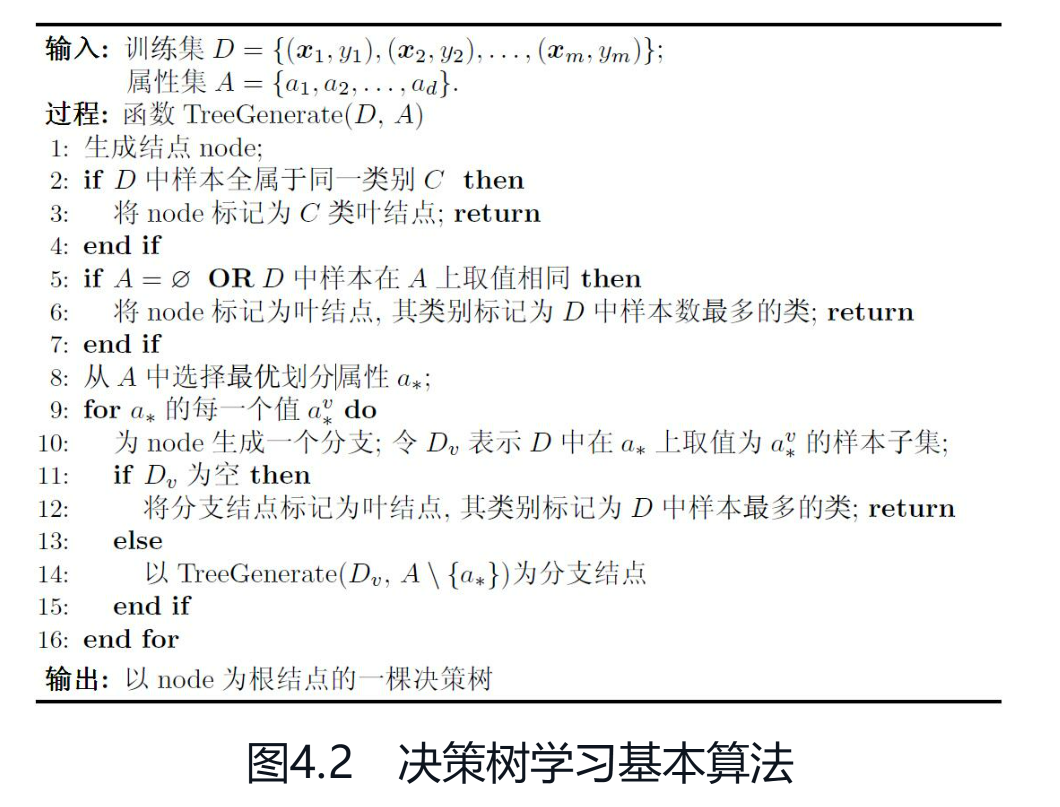

划分方法：


In [1]:
# 属性attr的取值大全
def attrAllvalue(D,attr):
  Allvalue = {}
  for d in D:
    Allvalue[d[attr]] = 0
  return Allvalue

def divDataByattr(D,attr):
  # 建立一个字典，key是attr的取值，已初始化数值为0
  re = attrAllvalue(D,attr)
  n = len(re) # 要划分出n个子数据集
  SubDataSets = {}
  for key,value in re.items():
    SubDataSets[key] = []
  for d in D:
    SubDataSets[d[attr]].append(d)
  return SubDataSets

# 获取maxnumClass
def calMaxClass(D,class_num):
  # 统计数据集D中各类样本的数目
  cal_class = [0 for i in range(class_num)]
  max = 0
  for d in D:
    cal_class[d['Class']]+=1
    if cal_class[d['Class']] > cal_class[max]:
      max = d['Class']
  return max,cal_class


In [2]:
import math
mm = pow(10,9)
# 信息增益
# D是数据集，cal_class是统计的各类样本的数量
# cal_class是一个数组，下标代表类别，值代表类别对应的数量
def Ent(D,cal_class):
  sum = len(D) # 样本总数
  # 求占比
  re = 0
  for k in cal_class:
    pk_class = k/sum
    if pk_class != 0:
      re -= pk_class* math.log(pk_class,2)

  return re

# 信息增益
def Gain(D,attr,class_info):
  max,cal_class = calMaxClass(D,class_num)
  EntD = Ent(D,cal_class)
  SubDataSets = divDataByattr(D,attr)
  EntDv = 0
  for value,Dv in SubDataSets.items():
    # cal_class
    max,cal_class=calMaxClass(Dv,class_num)
    class_info.append([max,cal_class])
    EntDv += float(len(Dv))/float(len(D))*Ent(Dv,cal_class)

  Gain_D_attr = EntD*mm-EntDv*mm
  print(f"属性{attr}的信息增益:{Gain_D_attr}")
  return Gain_D_attr



辅助函数：按照属性值划分数据集

In [3]:
## 步骤是attr，然后划分子数据集Dv，计算Ent(Dv)，记录attr相应的Gain和SubDataSets
## 选中Gain最小的attr之后直接调用SubDataSets即可

# 传入attr
# 计算attr的所有value值 attrAllvalue
# 根据value划分出subDataSets  divDataByattr

# 计算Dv 需要用到cal_class

def choseAttr(D,attrSet):
  compar = 0

  Gain_D = {}
  for attr in attrSet:
    SubDataSets = divDataByattr(D,attr)
    EntDv = 0
    # 补充上Dv额外的参数
    class_info = []
    Gain_D_attr = Gain(D,attr,class_info)
    # 记录数据集D用属性attr做划分时所有的已知信息，包括gain，数据子集，数据子集的class_num和max类
    Gain_D[attr] = {'gain':Gain_D_attr,'Dv':SubDataSets,'Dv_info':class_info}

  # 找gain最高的attr
  target = attrSet[0]
  for attr in attrSet:
    if Gain_D[attr]['gain'] >= compar:
      compar = Gain_D[attr]['gain']
      target = attr

  return target,Gain_D


In [4]:
# 说明：
# 设数据集是[{},{},{},...,{}]的格式
# {}的格式是{'attr1':'value1,'attr2':'value2',..,'label':'class'}
# label是结点node：表明其为叶节点还是非叶节点
# Class 是当node为叶结点时，该集合的类别
#
# 类别的数量
class_num = 2
class Node():
  def __init__(self,D,A,max,cal_class,class_num):
    self.data = D
    self.attr = A
    self.class_num = class_num
    self.cal_class = cal_class

    self.max = max
    self.label = 0 # 0表示非叶结点 1表示叶结点
    self.Class = max # 默认一个
    self.flag = "init"

  def isSameClass(self):
    if self.cal_class[self.max] == len(self.data):
      return True
    return False

  def isNoAttr(self):
    # 属性集为空
    if self.attr == None or self.attr==[]:
      return True,[]
    # 存储取值不同的属性
    self.Attr_Div = []
    for a in self.attr:
      a1 = self.data[0][a]
      for d in self.data:
        if d[a] != a1:
          self.Attr_Div.append(a)
          break
    # 无可分的属性
    if self.Attr_Div == []:
      return True,[]

    return False,self.Attr_Div



  # 计算选取最优划分属性
  def bestAttr(self):
    # 指向划分的子结点
    self.subDs = {}
    self.bestattr,self.Gain_D = choseAttr(self.data,self.Attr_Div)
    return self.bestattr,self.Gain_D

  def setflag(self,attr):
    self.flag = attr


  # 设置subDs
  def addsubDs(self,node,value):
    self.subDs[value] = node



In [5]:
import copy
import queue

def do_tree(tree):
  node = tree.get()
  print(node.data)

  # 判断D中的类别是不是都是一类
  re = node.isSameClass()

  if re:
    print("当前node都属于同一类别")
    # 如果D中的数据都属于同一个类别
    node.Class = node.max
    node.label = 1 # 标记为叶子结点
    return

  # D中的数据并不属于同一个类别
  # 判断属性是否可分
  boolre,Attr_Div = node.isNoAttr()
  print(f"Attr_Div={Attr_Div}")
  # D中的属性不可再分
  if boolre == True:
    print("当前类别属性不可再分")
    node.label = 1
    node.Class = node.max
    return

  # 选取最优属性
  attr,info = node.bestAttr()
  # 获取划分好的数据集
  SubDataSets = info[attr]['Dv']
  SubInfo = info[attr]['Dv_info']


  # 生成子node
  Attr = copy.deepcopy(Attr_Div)
  Attr.remove(attr)
  st = 0
  for value,subds in SubDataSets.items():
    # 因为假设是离散属性，所以新的self.attr必然要去掉已经选出的attr
    subnodeAttr = copy.deepcopy(Attr)
    # 获取已经算好的Dv的max和cal_class
    submax = SubInfo[st][0]
    subcal_class = SubInfo[st][1]
    st+=1

    # 生成新结点
    subnode = Node(subds,subnodeAttr,submax,subcal_class,class_num)
    subnode.setflag(attr)
    # 新结点还要继续加入tree进行讨论
    tree.put(subnode)

    # 父结点记录子结点的指引
    node.addsubDs(subnode,value)

def TreeGenerate(D,A):
  # 计算初始数据集的max和cal_class
  max,cal_class = calMaxClass(D,class_num)
  # 生成根结点
  node = Node(D,A,max,cal_class,class_num)

  tree = queue.Queue()
  tree.put(node)
  while tree.empty() == False:
    do_tree(tree)
  return node





# 读入原始的西瓜数据

In [6]:

dataSet = [
        # 1
        ['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '好瓜'],
        # 2
        ['乌黑', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', '好瓜'],
        # 3
        ['乌黑', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '好瓜'],
        # 4
        ['青绿', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', '好瓜'],
        # 5
        ['浅白', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '好瓜'],
        # 6
        ['青绿', '稍蜷', '浊响', '清晰', '稍凹', '软粘', '好瓜'],
        # 7
        ['乌黑', '稍蜷', '浊响', '稍糊', '稍凹', '软粘', '好瓜'],
        # 8
        ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '硬滑', '好瓜'],

        # ----------------------------------------------------
        # 9
        ['乌黑', '稍蜷', '沉闷', '稍糊', '稍凹', '硬滑', '坏瓜'],
        # 10
        ['青绿', '硬挺', '清脆', '清晰', '平坦', '软粘', '坏瓜'],
        # 11
        ['浅白', '硬挺', '清脆', '模糊', '平坦', '硬滑', '坏瓜'],
        # 12
        ['浅白', '蜷缩', '浊响', '模糊', '平坦', '软粘', '坏瓜'],
        # 13
        ['青绿', '稍蜷', '浊响', '稍糊', '凹陷', '硬滑', '坏瓜'],
        # 14
        ['浅白', '稍蜷', '沉闷', '稍糊', '凹陷', '硬滑', '坏瓜'],
        # 15
        ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '软粘', '坏瓜'],
        # 16
        ['浅白', '蜷缩', '浊响', '模糊', '平坦', '硬滑', '坏瓜'],
        # 17
        ['青绿', '蜷缩', '沉闷', '稍糊', '稍凹', '硬滑', '坏瓜']
    ]
Attr = ['色泽', '根蒂', '敲击', '纹理', '脐部', '触感']

# 硬编码类别
class_dict = {'坏瓜':0,'好瓜':1}

# 将数据合并格式
D = []
for i in range(len(dataSet)):
  d = {}
  for j in range(len(Attr)):
    d[Attr[j]] = dataSet[i][j]
  d['Class'] = class_dict[dataSet[i][-1]]
  D.append(d)

print(D)



[{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '稍凹', '触感': '软粘', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}, {'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '浅白', '根蒂': '硬挺', '敲击': '清脆', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}, {'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部'

# 初步构造一棵树

In [7]:
root = TreeGenerate(D,Attr)

[{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '稍凹', '触感': '软粘', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}, {'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '浅白', '根蒂': '硬挺', '敲击': '清脆', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}, {'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部'

## 尝试绘制图像

In [8]:
cur = root
# 表示区分的属性

q = queue.Queue()
q.put(cur)
while q.empty()==False:
  # 这层的宽度
  width = q.qsize()
  for i in range(width):
    # 用/**/包住一个node
    print(" /*",end="")
    cur = q.get()
    if cur.label == 1:
      # 叶子结点
      if cur.flag == "init":
        print(f"叶子:{cur.Class}原始数据集不划分",end="")
        break
      print(f"叶子：{cur.Class,cur.flag,cur.data[0][cur.flag]}",end="")
    else:
      l = len(cur.subDs)
      print(f"被分类依据：{cur.flag}",end="")
      if cur.flag != "init":
        print(f"值:{cur.data[0][cur.flag]}",end="  ")
      print(f",分支：{l}个",end="")

      for key,nod in cur.subDs.items():
        q.put(nod)

    print("*/ ",end="")
  print("")




 /*被分类依据：init,分支：3个*/ 
 /*被分类依据：纹理值:清晰  ,分支：2个*/  /*被分类依据：纹理值:稍糊  ,分支：2个*/  /*叶子：(0, '纹理', '模糊')*/ 
 /*叶子：(1, '触感', '硬滑')*/  /*被分类依据：触感值:软粘  ,分支：2个*/  /*叶子：(1, '触感', '软粘')*/  /*叶子：(0, '触感', '硬滑')*/ 
 /*被分类依据：脐部值:稍凹  ,分支：2个*/  /*叶子：(0, '脐部', '平坦')*/ 
 /*叶子：(1, '色泽', '青绿')*/  /*叶子：(0, '色泽', '乌黑')*/ 


In [9]:
def drawTree(root):
  cur = root
  # 表示区分的属性
  q = queue.Queue()
  q.put(cur)
  while q.empty()==False:
    # 这层的宽度
    width = q.qsize()
    for i in range(width):
      # 用/**/包住一个node
      print(" /*",end="")
      cur = q.get()
      if cur.label == 1:
        # 叶子结点
        if cur.flag == 'init':
          print(f"叶子：{cur.Class}原始数据集未划分",end="*/")
          break
        print(f"叶子：{cur.Class,cur.flag,cur.data[0][cur.flag]}",end="")
      else:
        l = len(cur.subDs)
        print(f"被分类依据：{cur.flag}",end="")
        if cur.flag != "init":
          print(f"值:{cur.data[0][cur.flag]}",end="  ")
        print(f",分支：{l}个",end="")

        for key,nod in cur.subDs.items():
          q.put(nod)

      print("*/ ",end="")
    print("")




## 预测

In [10]:
def predict(data,root):
  cur = root
  while cur.label != 1:
    attr = cur.bestattr
    cur = cur.subDs[data[attr]]
  return cur.Class

for d in D:
  pd_label = predict(d,root)
  if pd_label == 0:
    print("坏瓜")
  else:
    print("好瓜")


好瓜
好瓜
好瓜
好瓜
好瓜
好瓜
好瓜
好瓜
坏瓜
坏瓜
坏瓜
坏瓜
坏瓜
坏瓜
坏瓜
坏瓜
坏瓜


# 决策树（二）

## 划分训练集和验证集
1. 从好瓜里面选出3个
2. 从坏瓜里面选出3个

为了显示方便，写个逐行打印

In [42]:
import numpy as np
def show(D):
  for i in D:
    print(i)

good_index = np.arange(0, 8, 1, dtype=np.int16)
np.random.shuffle(good_index)
print(f"好瓜打乱后的索引={good_index}")

bad_index = np.arange(8,17,1,dtype=np.int16)
np.random.shuffle(bad_index)
print(f"坏瓜打乱后的索引{bad_index}")

train_data = [ D[i] for i in good_index[3:]]+[D[i] for i in bad_index[3:]]
val_data = [D[i] for i in good_index[:3]] + [D[i] for i in bad_index[:3]]
print("训练集的数据为")
show(train_data)
print("验证集的数据为")
show(val_data)




好瓜打乱后的索引=[6 2 3 5 4 0 7 1]
坏瓜打乱后的索引[12 14 10  9 16 13 11 15  8]
训练集的数据为
{'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}
{'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Clas

## 完善预测过程
考虑以下可能：<br>
 预测样本中出现新的属性值




如果样本中出现新的属性值，则将测试样本划为当前结点最多类的类别

In [65]:
def predict_v2(data,root):
  cur = root
  # 打印一下root的地址

  while cur.label != 1:
    attr = cur.bestattr
    key = data[attr]
    # 如果样本出现新的属性值，则这个样本被标记为当前结点数量最多的类别
    if key not in cur.subDs:
      return cur.max

    cur = cur.subDs[key]
  return cur.Class

# 精度计算
def calAccuracy(pred,data):
  n = len(data)
  re = 0
  for i in range(n):
    if pred[i] == data[i]['Class']:
      re+=1
  return re/n

## 测试v2

In [13]:
# 建树
root_v2 = TreeGenerate(train_data,Attr)
# 画图
drawTree(root_v2)


re = []
for i in range(len(val_data)):
  re.append(predict_v2(val_data[i],root_v2))

print(f"精度是:{calAccuracy(re,val_data)}")

[{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '稍凹', '触感': '软粘', 'Class': 1}, {'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 0}, {'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}, {'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}, {'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}]
Attr_Div=['色泽', '根蒂', '敲击', '纹理', '脐部', '触感']
属性色泽的信息

# 测试v3

从数据集划分上优化模型：
1. 数据集划分：首先，你将原始数据集分成两部分：训练集和验证集。训练集用于构建决策树，验证集用于评估模型的性能。
2. 决策树构建：使用训练集，你可以生成一颗决策树。决策树是一种基于特征的分类模型，它通过一系列的分支节点来预测目标变量。
3. 模型评估：接下来，你使用验证集来评估决策树的性能。计算模型在验证集上的精度，这将告诉你模型的分类准确率。
4. 记录结果：记录当前决策树的精度和模型结构。这对于后续比较不同模型非常重要。
5. 尝试不同划分方式：你提到了尝试不同的数据集划分方式。这是一个很好的做法！你可以尝试不同的训练集和验证集组合，例如交叉验证或不同的随机划分。
6. 比较模型：使用不同划分方式构建多个决策树，并在验证集上计算它们的精度。选择具有最高精度的模型作为最终的决策树。



In [14]:
# 打乱顺序
def shuffle(D):
  index = np.arange(0,len(D),1,dtype=np.int16)
  cpD = copy.deepcopy(D)
  np.random.shuffle(cpD)
  return cpD

D_v3 = shuffle(D)
show(D_v3)

{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '硬挺', '敲击': '清脆', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '硬滑', 'Class': 1}
{'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}
{'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感'

In [15]:
def CreateByK(D,k):
  # 根据k折将数据集D划分出若干大小为k的子集
  n = int(len(D)/k)
  re = []
  for i in range(n):
    re.append(D[k*i:i*k+k])
  re.append(D[n*k:])
  return re


Ds_K = CreateByK(D_v3,3)
show(Ds_K)



[{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}]
[{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '浅白', '根蒂': '硬挺', '敲击': '清脆', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '硬滑', 'Class': 1}]
[{'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}, {'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}]
[{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '

接下来只需用Ds_K划分好的子集，形成不同的训练集和验证集组合生成不同的模型

In [16]:
# 打包验证过程
def evaluate(val_data,root):
  re = []
  for i in range(len(val_data)):
    re.append(predict_v2(val_data[i],root))
  ans = calAccuracy(re,val_data)
  print(f"精度是:{ans}")
  return ans

def CreateTrain_data(Ds_K,i):
  train_data = []
  for j in range(len(Ds_K)):
    if j != i:
      train_data += Ds_K[j]
  return train_data

def trainByK(Ds_K,Attr):
  n = len(Ds_K)
  models = []
  for i in range(n):
    train_data = CreateTrain_data(Ds_K,i)

    val_data = Ds_K[i]
    print(val_data)
    # 生成模型
    root = TreeGenerate(train_data,Attr)

    # 计算训练集上的精度
    acc_train = evaluate(train_data,root)

    # 用验证集预测并计算精度
    acc_val = evaluate(val_data,root)
    models.append({'model':root,'acc':acc_train,'acc_val':acc_val})
  return models

models = trainByK(Ds_K,Attr)
target = 0
for i in range(len(models)):
  if models[i]['acc']+models[i]['acc_val'] > models[target]['acc']+models[target]['acc_val']:
    target = i

drawTree(models[target]['model'])
print(f"模型在训练集上的损失:{models[target]['acc']},在验证集上的损失:{models[target]['acc_val']}")

[{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}]
[{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '浅白', '根蒂': '硬挺', '敲击': '清脆', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '硬滑', 'Class': 1}, {'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}, {'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}, {'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}, {'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}, {'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部

# 测试v4
p次k折交叉验证<br>
按照西瓜书：
1. 交叉验证法”(cross validation)先将数据集D划分为k个大小相似的互斥子集
2. 每个子集Di都尽可能保持数据分布的一致性，即从D中通过分层采样得到。然后，每次用k-1个子集的并集作为训练集，余下的那个子集作为测试集；这样就可获得k组训练/测试集，从而可进行k次训练和测试，最终返回的是这k个测试结果的均值
3. k折交叉验证通常要随机使用不同的划分重复p次，最终的评估结果是这p次k折交叉验证结果的均值

# 预剪枝和后剪枝

## 预剪枝

1. 构造出训练集和验证集——利用"决策树(二)的代码"<br>



In [60]:
train_data = D[0:3]+D[5:7]+[D[9]]+D[13:]
val_data = D[3:5]+[D[7]]+D[8:13]
print("训练集")
show(train_data)
print("验证集")
show(val_data)



训练集
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}
验证集
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹

In [52]:
# 精度计算
def calAccuracy(pred,data):
  n = len(data)
  re = 0
  for i in range(n):
    if pred[i] == data[i]['Class']:
      re+=1
  return re/n

# 返回预测结果和精度
def predict_v4(root,val_data):
  re = []
  for i in range(len(val_data)):
    re.append(predict_v2(val_data[i],root))
  return re,calAccuracy(re,val_data)



In [19]:
# 若是否有划分的资格
def CanDivide(node_v4):
  if node_v4.isSameClass() == True:
    return False,[]

  boolre,Attr = node_v4.isNoAttr()
  if boolre == False:
    return True,Attr
  return False,[]

In [20]:
import queue
# 找出初始数据集的最多类
max,cal_class = calMaxClass(train_data,class_num)
# 构造训练集的根结点
root_v4 = Node(train_data,Attr,max,cal_class,class_num)
# 标记根结点位叶结点
root_v4.label = 1

# 初始化waitcheck队列
waitcheck = queue.Queue()
waitcheck.put(root_v4)

def train_v4(waitcheck,root_v4):
  node_v4 = waitcheck.get()
  # 用验证集算一下精度
  res_o,acc_o = predict_v4(root_v4,val_data)

  divide,Attr_Div = CanDivide(node_v4)
  if divide == False:
    # 考虑下一个结点
    print("考虑下一个结点")
    return
  else:
    # 先将当前结点的label改为0
    node_v4.label = 0

    # 尝试划分结点
    # 选取最优属性
    attr,info = node_v4.bestAttr()
    # 获取划分好的数据集
    SubDataSets = info[attr]['Dv']
    SubInfo = info[attr]['Dv_info']


    # 生成子node
    # 保持子node
    savesubnode = []
    Attr = copy.deepcopy(Attr_Div)
    Attr.remove(attr)
    st = 0
    for value,subds in SubDataSets.items():
      # 因为假设是离散属性，所以新的self.attr必然要去掉已经选出的attr
      subnodeAttr = copy.deepcopy(Attr)
      # 获取已经算好的Dv的max和cal_class
      submax = SubInfo[st][0]
      subcal_class = SubInfo[st][1]
      st+=1

      # 生成新结点
      subnode = Node(subds,subnodeAttr,submax,subcal_class,class_num)
      subnode.setflag(attr)
      # 假设新结点都是叶子结点
      subnode.label = 1

      # 暂存取得的新结点，若确定要划分，才加入讨论队列
      savesubnode.append(subnode)

      # 父结点记录子结点的指引
      node_v4.addsubDs(subnode,value)


    # 验证集评估
    res_d,acc_d = predict_v4(node_v4,val_data)
    print(f"未划分时的分类精度:{acc_o},划分后的分类精度:{acc_d}")
    print(f"展示一下划分后的树")
    drawTree(root_v4)
    if acc_d>acc_o:
      # 划分后的精度更高，所以划分
      # 将新的子结点加入waitcheck
      for i in savesubnode:
        # i.label = 0 不用改，取出来还要再令label=1
        waitcheck.put(i)
    else:
      # 划分后验证集的预测结果
      print("划分后验证集预测结果")
      print(res_d)
      # 最终还是不划分
      node_v4.label = 1

while waitcheck.empty()==False:
    train_v4(waitcheck,root_v4)

drawTree(root_v4)

属性色泽的信息增益:275488750.21634674
属性根蒂的信息增益:114524702.77266574
属性敲击的信息增益:173533749.35095942
属性纹理的信息增益:173533749.35095942
属性脐部的信息增益:275488750.21634674
属性触感的信息增益:0.0
未划分时的分类精度:0.375,划分后的分类精度:0.75
展示一下划分后的树
 /*被分类依据：init,分支：3个*/ 
 /*叶子：(1, '脐部', '凹陷')*/  /*叶子：(1, '脐部', '稍凹')*/  /*叶子：(0, '脐部', '平坦')*/ 
属性色泽的信息增益:811278124.4591328
属性根蒂的信息增益:811278124.4591328
属性敲击的信息增益:311278124.4591328
属性纹理的信息增益:811278124.4591328
未划分时的分类精度:0.75,划分后的分类精度:0.875
展示一下划分后的树
 /*被分类依据：init,分支：3个*/ 
 /*被分类依据：脐部值:凹陷  ,分支：2个*/  /*叶子：(1, '脐部', '稍凹')*/  /*叶子：(0, '脐部', '平坦')*/ 
 /*叶子：(1, '纹理', '清晰')*/  /*叶子：(0, '纹理', '稍糊')*/ 
属性色泽的信息增益:0.0
属性根蒂的信息增益:311278124.4591328
属性敲击的信息增益:311278124.4591328
属性纹理的信息增益:0.0
属性触感的信息增益:311278124.4591328
未划分时的分类精度:0.875,划分后的分类精度:0.875
展示一下划分后的树
 /*被分类依据：init,分支：3个*/ 
 /*被分类依据：脐部值:凹陷  ,分支：2个*/  /*被分类依据：脐部值:稍凹  ,分支：2个*/  /*叶子：(0, '脐部', '平坦')*/ 
 /*叶子：(1, '纹理', '清晰')*/  /*叶子：(0, '纹理', '稍糊')*/  /*叶子：(1, '触感', '软粘')*/  /*叶子：(0, '触感', '硬滑')*/ 
划分后验证集预测结果
[1, 1, 0, 0, 0, 0, 0, 0]
考虑下一个结点
考虑下一个结点
考虑下一

## 后剪枝
1. 划分训练集和验证集
2. 生成一棵训练集完整的树
3. 收集树的所有非叶结点
4. 从最底层的非叶结点开始考虑：<br>
  如果划分：验证集精度=a<br>
  如果不划分，令当前结点的label=1，class=max，验证集精度=b
  比较a和b的大小:<br>
  如果a>b 则划分,令当前结点label = 0
  如果a<=b 则不划分，令当前结点的label=1

1、划分训练集和验证集【和预剪枝的数据划分一致】

In [61]:
train_data = D[0:3]+D[5:7]+[D[9]]+D[13:]
val_data = D[3:5]+[D[7]]+D[8:13]
print("训练集")
show(train_data)
print("验证集")
show(val_data)


训练集
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}
验证集
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹

2、生成一棵训练集完整的树

In [62]:
show(train_data)
root_v5 = TreeGenerate(train_data,Attr)
drawTree(root_v5)

{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}
{'色泽': '青绿', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '稍糊', '脐部': '稍凹', '触感': '软粘', 'Class': 1}
{'色泽': '青绿', '根蒂': '硬挺', '敲击': '清脆', '纹理': '清晰', '脐部': '平坦', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '稍蜷', '敲击': '沉闷', '纹理': '稍糊', '脐部': '凹陷', '触感': '硬滑', 'Class': 0}
{'色泽': '乌黑', '根蒂': '稍蜷', '敲击': '浊响', '纹理': '清晰', '脐部': '稍凹', '触感': '软粘', 'Class': 0}
{'色泽': '浅白', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '模糊', '脐部': '平坦', '触感': '硬滑', 'Class': 0}
{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '稍糊', '脐部': '稍凹', '触感': '硬滑', 'Class': 0}
[{'色泽': '青绿', '根蒂': '蜷缩', '敲击': '浊响', '纹理': '清晰', '脐部': '凹陷', '触感': '硬滑', 'Class': 1}, {'色泽': '乌黑', '根蒂': '蜷缩', '敲击': '沉闷', '纹理': '清晰', '脐部': '凹陷', '触

3、收集树的所有非叶结点<br>
层序遍历


In [66]:
def collectAllNoLeaf(root):
  NoLeafQ = queue.Queue()
  NoLeafS = []
  if root.label == 1:
    # 根结点本身是叶子，那就没有讨论空间了
    print(f"根结点本身是叶子")
    return NoLeafS

  NoLeafQ.put(root)
  NoLeafS.append(root)

  while NoLeafQ.empty() == False:
    # 当前层的结点数目
    n = NoLeafQ.qsize()
    for i in range(n):
      cur = NoLeafQ.get()
      # cur结点的子结点的数目
      for value,node in cur.subDs.items():
        if node.label != 1:
          # 子结点不是叶子结点

          NoLeafS.append(node)
          NoLeafQ.put(node)
  return NoLeafS
NoLeafnodes = collectAllNoLeaf(root_v5)

4、从最底层的非叶结点开始考虑：<br>
  如果划分：验证集精度=a<br>
  如果不划分，令当前结点的label=1，class=max，验证集精度=b
  比较a和b的大小:<br>
  如果a>b 则划分,令当前结点label = 0
  如果a<=b 则不划分，令当前结点的label=1

In [69]:
# 倒叙遍历
def train_v5(NoLeafnodes,root,val_data):
  n = len(NoLeafnodes)

  for i in range(n):

    cur = NoLeafnodes[n-1-i]

    # 沿用predict_v4 精度计算方法

    res_o,acc_o = predict_v4(root,val_data)
    print(f"划分的预测序列{res_o}")
    # 假如当前不划分
    cur.label = 1
    cur.Class = cur.max
    # 计算精度
    res_d,acc_d = predict_v4(root,val_data)
    print(f"不划分的预测序列{res_d}")
    if acc_o > acc_d:
      # 划分的精度更高
      print(f"划分的精度更高，划分了以后{acc_o}\t不划分{acc_d}")
      cur.label = 0
    else:
      print(f"不划分的精度更高，划分了以后{acc_o}\t不划分{acc_d}")
  return root

r = train_v5(NoLeafnodes,root_v5,val_data)
drawTree(r)


划分的预测序列[1, 1, 1, 1, 0, 0, 0, 0]
不划分的预测序列[1, 1, 1, 1, 0, 0, 0, 1]
划分的精度更高，划分了以后0.875	不划分0.75
划分的预测序列[1, 1, 1, 1, 0, 0, 0, 0]
不划分的预测序列[1, 1, 1, 1, 1, 1, 1, 1]
划分的精度更高，划分了以后0.875	不划分0.375
 /*被分类依据：init,分支：3个*/ 
 /*被分类依据：脐部值:凹陷  ,分支：2个*/  /*叶子：(1, '脐部', '稍凹')*/  /*叶子：(0, '脐部', '平坦')*/ 
 /*叶子：(1, '纹理', '清晰')*/  /*叶子：(0, '纹理', '稍糊')*/ 
